<a href="https://colab.research.google.com/github/poorvigupta26/image-matting-with-MODnet/blob/main/image_matting_with_MODNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

#pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt


/content
Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 276 (delta 21), reused 16 (delta 16), pack-reused 236 (from 1)
Receiving objects: 100% (276/276), 60.77 MiB | 33.42 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/content/MODNet
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
100% 26.3M/26.3M [00:00<00:00, 47.1MB/s]


In [ ]:
import shutil
from google.colab import files


input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

image_names = list(files.upload().keys())
for image_name in image_names:
  shutil.move(image_name, os.path.join(input_folder, image_name))


Saving omid-bonyadian-J4qDjCD7xDw-unsplash.jpg to omid-bonyadian-J4qDjCD7xDw-unsplash.jpg


In [ ]:
!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


Process image: omid-bonyadian-J4qDjCD7xDw-unsplash.jpg


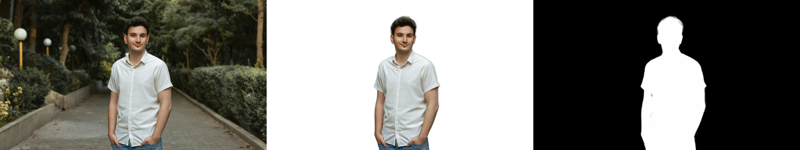

omid-bonyadian-J4qDjCD7xDw-unsplash.jpg 



In [ ]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))

  # predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)

  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  display(combined_display(image, matte))
  print(image_name, '\n')


In [ ]:
zip_filename = 'matte.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)

os.system(f"zip -r -j {zip_filename} {output_folder}/*")
files.download(zip_filename)

In [ ]:
import cv2
import numpy as np

fg = cv2.imread("/content/modnet-fg.png")                    # foreground
alpha = cv2.imread("/content/omid-bonyadian-J4qDjCD7xDw-unsplash.png", cv2.IMREAD_GRAYSCALE) / 255.0  # normalize
rgba = cv2.merge((fg[:, :, 0], fg[:, :, 1], fg[:, :, 2], (alpha * 255).astype(np.uint8)))
cv2.imwrite("final_fg.png", rgba)


True